# Public transport in Vienna

Name: Elena Lisa Monika Gaggia

### Step 1: Describing the data

In [1]:
dataset1= {
    "creator" : "Stadt Wien" ,
    "catalogName" : "Open Data Österreich" ,
    "catalogURL" : "https://www.data.gv.at" ,
    "datasetID" : "https://www.data.gv.at/katalog/dataset/f1f6f15d-2faa-4b62-b78b-80599dd1c66e" ,
    "resourceURL" : "https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:OEFFHALTESTOGD&srsName=EPSG:4326&outputFormat=csv"  ,
    "pubYear" : "2014"  ,
    "lastAccessed" : "2022-03-27T23:55:00"
}

dataset2= {
    "creator" : "Stadt Wien" ,
    "catalogName" : "Open Data Österreich" ,
    "catalogURL" : "https://www.data.gv.at" ,
    "datasetID" : "https://www.data.gv.at/katalog/dataset/aac2629e-495d-4468-9c8b-cd9649bd7b5d" ,
    "resourceURL" : "https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:AUFZUGOGD&srsName=EPSG:4326&outputFormat=json"  ,
    "pubYear" : "2011"  ,
    "lastAccessed" : "22-03-27T23:55:00"
}

**Dataset 1:**

The first dataset was published by the City of Vienna and lists the respective stops of the various public transport systems throughout Vienna.  It can be accessed via the portal "Open Data Österreich" which offers free access to data dealing with all kinds of different topics in Austria to the public. This dataset provides interesting information about which areas of Vienna are increasingly served by public transport.

**Dataset 2:**

The second dataset was also published by the City of Vienna and can be accessed via the portal "Open Data Austria" as well. It provides information on the presence of elevators at the various stations in Vienna. In the dataset, mainly stops of the subway lines are listed. From this it can be concluded not only that some areas in Vienna are not equipped with any subway network, but that at certain junctions are larger stations which also have many elevators.

**Project ideas:**

Both datasets include the respective stopping points of the different types of public transport. This way the datasets can be merged perfectly.

Research questions:

- Is there a correlation between certain areas/hotspots in Vienna and how many elevators have been installed (i.e. Karlsplatz, Hauptbahnhof, Mariahilferstraße...)?

- How many elevators will probably have to be build at the various stops of the new subway line U5?

As installing elevators is very expensive the answers to these questions could therefore also have played a role in the planning of the U5 extension. Furthermore, this is crucial information in order to understand past and future planning of Vienna.



### Step 2: Accessing the data

In [4]:
import requests

# Write a Python function that takes the dataset dictionary (datadict) created in Step 0 as an input and returns an extended dictionary
def accessData(datadict):
    
    # Define URL which is defined as "resourceURL" in the dataset dictionary
    url = datadict["resourceURL"]
    
    # Make a request (r) to the URL; as we imported the requests library use the requests.get() function
    r = requests.get(url) 
    
    # Handling key error 'content length'
    
    ## Body encoding: In HTTP/1.0 the only option was to use Content-Length; this is necessary for the HTTP client to know when the response ends because then a new HTTP request could be sent; this was especially problematic in streaming because the end was unknown as in that case this would in theory have an infinitive stream of data
    # Check for "transfer-encoding: chunked" in the request
    is_chunked = r.headers.get('transfer-encoding', '') == 'chunked' 
    # Check for content length (i.e. content-length = 20166)
    content_length_s = r.headers.get('content-length')
    
    # Calculate content-length -> is digit() method returns true when all characters are digits
    if not is_chunked and content_length_s.isdigit():
        # Converts specified value into integer object
        content_length_s = int(content_length_s)
        # Divide by 1024 to get from bytes to KB
        file_size = content_length_s/1024
     
    # If the header contains no content length because encoding is chunked get the size with os module
    elif content_length_s is not r.headers:  
        import os
        # Use os module to get the file size and divide it by 1024 to convert it from Bytes to KB
        file_size = os.path.getsize("./data/./data_notebook-1_OEFFHALTESTOGD.csv")/1024
    # If that doesn´t work set the file size to 0
    else:
        file_size = 0
    
    # Extensions
    
    # List of extensions that can be added to the data dictionary
    valid_extentions = ['XML', 'JSON', 'CSV', 'TSV'] 

    # Get the last character after the '=' in the URL, which was defined before -> returns csv and json
    extention = url.split('=')[-1].lower()
    
    # If extention is valid add to the dictionary
    if extention in valid_extentions: 
        datadict['detectedFormat'] = extention
        
    # If extention cannot be found from the URL check the Content-Type in the HTTP header
    else: 
        content_type = r.headers['Content-Type']
        
        # Initialise a new variable for the extention, set to unknown, update if file type can be found
        ext = 'unknown' 
        for e in valid_extentions: 
            if e in content_type.upper():
                
                # If a valid file type is detected update the variable 'ext'
                ext = e 
        datadict['detectedFormat'] = ext

    # Detect the file size
        if datadict['detectedFormat'] == 'unknown':
            datadict['filesizeKB'] = 0
        else:
            datadict['filesizeKB'] = round(file_size,2)
                
    return datadict

**Dataset 1:**

The format of the data set is CSV and the size 568.51 KB.
Other remarks: As the encoding was chunked I was not able to get the file size out of the HTTP-header. When an encoding is chunked the header does not contain the field content length. As solved the problem with another method as described above.*

**Dataset 2:**

The format of the data set is JSON and the size 125.48 KB.

### Step 3: Format Validation

**Data set 1**

I used the format validator http://csvlint.io. It confirmed that the CSV-file is valid. However, it advised to address that the data in column 6 is inconsistent with other headers. In my case this is not a problem for further continuation of the project since there are different means of transportation, which are named differently.

**Data set 2**

For the JSON-file I used the validator https://jsonformatter.curiousconcept.com. It confirmed that the JSON-file is valid and can be therefore be used without further notive.

In [6]:
pip install xmltodict

Note: you may need to restart the kernel to use updated packages.


In [7]:
import requests
import csv
import json
import xmltodict
import codecs
import urllib.request

def parseFile(datadict, format):
    
    # Define formats
    formats = ["CSV","XML","JSON"]
    
    # If format is CSV assign the following delimiters
    if format == "CSV":
        delimiters = [",", ";", "\t"]
        
        # Request URL from Step 0
        r = requests.get(datadict['resourceURL'])
        
        # Count delimiters -> turns out to be unnecessary
        # count = 0
        # for i in delimiters:
            # y = r.text.count(i)
            # delimiters[count] = y
            # count = count + 1
        # y = 0
        
        # Using codecs.iterdecode() to iteratively decode the input in UTF8
        csvfile = csv.reader(codecs.iterdecode(r.iter_lines(), 'utf-8'), delimiters)
        
        # Headerline -> one needs to be skipped because of the header
        length_line = len(next(csvfile))
        
        # Count if every row has the same number of elements
        for line in csvfile: 
            if len(line) != length_line:
                length_line = 0
        if length_line == 0:
            return False
        else:
            return True
        
    # If format is "JSON"
    if format == "JSON":
        
        # Open URL from Step 0
        resp = urllib.request.urlopen(datadict['resourceURL']).read() 
        
        # Test for errors; if it works return True
        try:
            data = json.loads(resp.read()) 
            return True
        
        # If it doesn´t work return False
        except: 
            return False
            
    # If format is "XML"
    if format == "XML":
        with urllib.request.urlopen(datadict['resourceURL']):
            
        # Use xmltodict to make XML file feel like a JSON file and test for errors; if it works return True
            try:
                x=(xmltodict.parse(f.read())) 
                return True    
            
            # If it doesn´t work return False
            except:
                return False
    
    # If any other format is detected return False
    if format not in f:
        return False

### Step 4: Content analysis

In [8]:
import csv
import requests
import urllib.request
import codecs 
import json

def describeFile(datadict):
    url=datadict["resourceURL"]
    extention = url.split('=')[-1].lower() # get the last character after the '=' in the URL

    # Process for CSV:
    if extention == 'csv':     
        result_dict = {} # empty dictionary where we will put our results in later
        resp = urllib.request.urlopen(url) # open the connection
        csvfile = csv.reader(codecs.iterdecode(resp, 'utf-8')) # csv.reader requires a iterator object

        # number of columns
        ncol = len(next(csvfile)) 
        result_dict["numberOfColumns"] = ncol
        
        # number of rows
        nrows = sum(1 for row in csvfile) + 1 # add 1 to include the header
        result_dict["numberOfRows"] = nrows
        
        # column with longest entry
        longest_item = 0 
        longest_column = 0
        column = 0
        for row in csvfile:
            while column < num_column:
                current_item_length = len(row[column]) # iterate the item length under each column in a row 
                if current_item_length > longest_item: # here we find the longest item 
                    longest_item = current_item_length 
                    longest_column = column # here we specifiy the column number that contains the longest item
                column += 1
        result_dict["longestColumn"] = longest_column
        
        return(result_dict)
        
    # Process for Json
    elif extention == 'json':
        result_dict = {}
        with urllib.request.urlopen(datadict["resourceURL"]) as f:
            jsonfile = json.load(f) # reading our file

            # number of attributes
            attributes = list(jsonfile)
            numberOfAttributes = len(list(dict.fromkeys(attributes))) #dictionary with attributes converted to a list (deleting duplicates) and getting the number
            result_dict["numberOfAttributes"] = numberOfAttributes

            # nesting depth
            dict_string = str(jsonfile)
            depth = 0
            for i in dict_string :
                if i == "{" or i =="[": # increase depth number with each new bracket
                    depth += 1
                elif i == "}": # end loop with closing bracket
                    break
            result_dict["nestingDepth"] = depth

            # length of the longest list
            lengthslist = []
            for key in jsonfile: # iterating through each key
                if type(jsonfile[key]) == list: 
                    lengthslist.append(len(jsonfile[key])) 
            result_dict["longestListLength"] = max(lengthslist)

            return(result_dict)
        
    # For other file formats
    else:
        result_dict = {}
        return(result_dict)

**Data set 1**

The CSV file includes 9 columns which describe the data entries about the public transport stations in Vienna. From these information such as location, the type of public transport (i.e. bus or subway) and which other lines use that station can be extracted. Overall, there are 4766 rows including the header. The column that includes the longest entry is the first one (column 0), which indicates the ID of the station/row.


**Data set 2**

The JSON file includes four main attributes and the data about the elevators is nested within the "features" attribute. The nested attributes include, for example, the coordinates, the public transport line and the station name where it is located. The nesting depth is five. The longest list is also contained in the features attribute and has a length of 305.

### Visualing Dataset 1

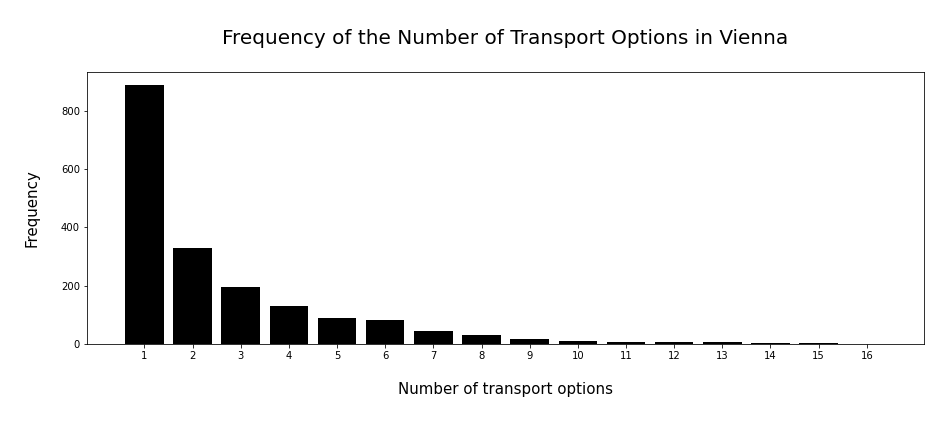

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Import CSV
data1_df = pd.read_csv('OEFFHALTESTOGD.csv')

# Define stopping_place and transport_type with the right columns from the dataframe
stopping_place = data1_df['HTXT']
transport_type = data1_df['LTYP']

# Concatenate (verketten) objects along one axis -> create this data frame for further analysis
step1_df = pd.concat([stopping_place, transport_type], axis=1)

# Collect data for the histogram
place_names = []
num_transports = []

# Go trough data frame and add to the lists -> first column then second column
for group in step1_df.groupby('HTXT'):
    place_names.append(group[0])
    num_transports.append(sum(group[1].value_counts()))

frequency = list(pd.DataFrame(num_transports).value_counts()) # Avoid barchart from overlapping

# Create barchart and style
fig, ax = plt.subplots(figsize=(15,5)) # Create figure and multiple axis 
ax.bar(list(range(1,len(frequency)+1)), frequency, color = 'black') # Automatically determines needed length for the axis 
ax.set_xlabel('\nNumber of transport options\n', fontsize=15)
ax.set_ylabel('\nFrequency\n', fontsize=15)
ax.set_title('\nFrequency of the Number of Transport Options in Vienna\n', fontsize=20)
ax.set_xticks(list(range(1,len(frequency)+1))) # Avoid barchart from overlapping by setting x tick locations

According to Saket et al. (2019) the task on the datasource is to characterize distribution. The attribute of interest of our datasets is the number of transport options in a station which I calculated before visualizing the barchart. 

A bar chart is very effective in that sense, as it provides a visual representation of the distribution in the dataset. Furthermore, it is the fastest and the most accurate visualization type. As stated in the article, the result is similar to that of previous studies, showing that people can decode values with length faster than with, for example, angle or volume. (Saket, Endert, Demiralp, 2015, Journal of Latex Class Files, Vol. 14, page 5)

The barchart is right-skewed, as most public transport stations only connect one or two means of transport. Only a few hotspots in Vienna give access to a larger amount of means of public transport.

This contributes to my project a lot, as it would make sense when looking at the correlation between the number of modes of transport and the number of elevators in Step 3, that there are a lot of small public transport stations in Vienna, which do not have or need an elevator (i.e. bus).

### Visualising Dataset 2

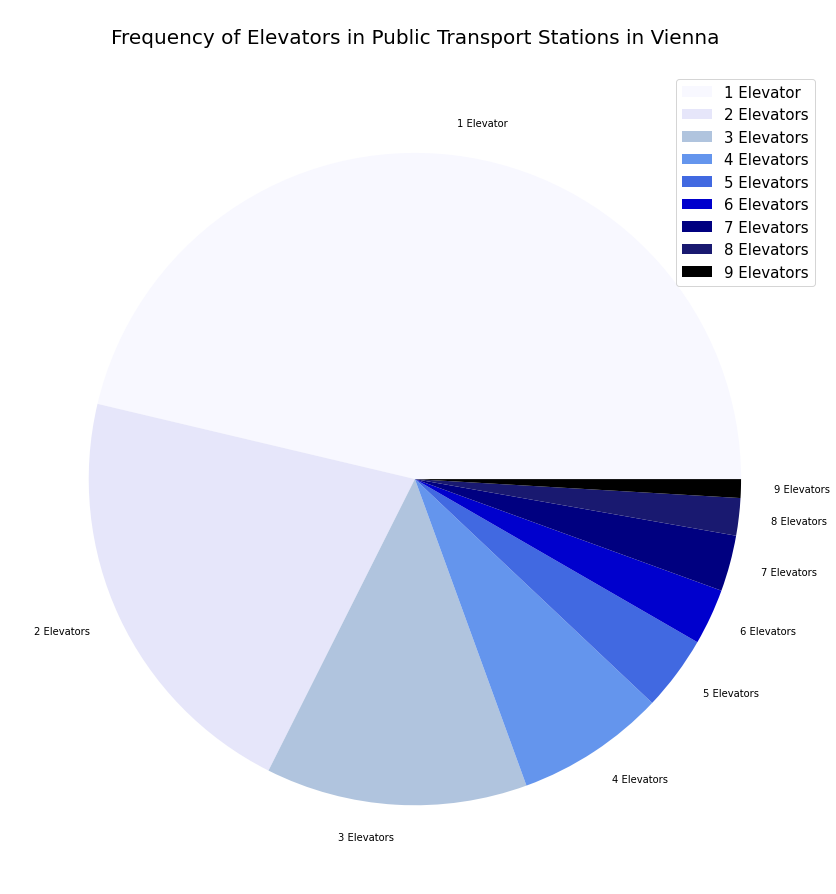

In [12]:
import json

# Import JSON
with open('AUFZUGOGD.json') as f:    
    data2 = json.load(f)  

# Define elevators
elevators = [feature['properties']['STATION'] for feature in data2['features'] if feature['properties']['STATION'] != None]

# Choose stations
elevator_df = pd.DataFrame(elevators, columns=['Stations'])
elevator_group = elevator_df.groupby('Stations')
# elevator_counts = elevator_group.value_counts()

# Create dataframe
station_names = [station[0].title() for station in elevator_group] # title() changes uppercase names to titles
num_elevators = [station[1].count()[0] for station in elevator_group]
station_elevators = pd.DataFrame({'HTXT':station_names, 'Num Elevators':num_elevators})

# Define frequency of the given number of elevators in the dataset
frequency = list(pd.DataFrame(num_elevators).value_counts())

# Define index names
index_names = [f'{i} Elevators' for i in range(1,len(frequency)+1)]
index_names[0] = '1 Elevator'

# Create piechart and style
pie_df = pd.DataFrame({'Frequency':frequency}, index=index_names)
colors = ['ghostwhite', 'lavender', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'navy', 'midnightblue', 'black']
ax = pie_df.plot(kind='pie', y='Frequency', figsize = (15, 15), colors = colors)
ax.set_ylabel('')
ax.set_title('\nFrequency of Elevators in Public Transport Stations in Vienna\n', fontsize=20)
ax.legend(loc='upper right', fontsize=15)

According to Saket et al. (2019) the task on the datasource is to find clusters. For this matter, a piechart is an excellent visualization tool, as it has a high accuracy and gives the user a quick overview of similarities between stations regarding the amount of elevators, which works very well as the number of data points visualized is small. Additionally, a pie chart is a very fast visualisation tool and it effectively shows the proportion of elevators taken up by each station (part-whole visualization). (Saket, Endert, Demiralp, 2015, Journal of Latex Class Files, Vol. 14, page 5, 7)

In my case, the pie chart shows the frequency of elevators in public transport stations. A high proportion of public transport stations only have one elevator. That is very interesting since it seems like stations with more elevators are located in more popular places or districts in Vienna. 

This also confirms my assumption that the more public transport options are connected, the more elevators are build at those stations.

### Merging and plotting the two datasets

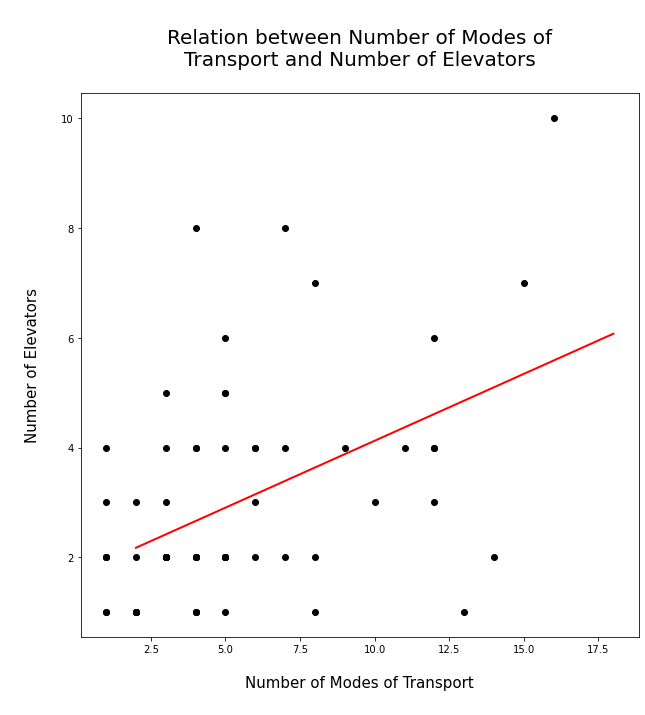

In [13]:
from sklearn.linear_model import LinearRegression

# Define new dataframes
transport_df = pd.DataFrame({'HTXT':place_names, 'Num Transport': num_transports})
pie_df['HTXT'] = [name.title() for name in pie_df.index]

# Merge datframes and drop duplicates; how = inner only is the default method and defines that only common values are merged
merged_df = pd.merge(transport_df, station_elevators, how='inner')
merged_df = merged_df.drop_duplicates(subset=['HTXT'])

# Create scatterplot
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(merged_df['Num Transport'], merged_df['Num Elevators'], color = 'black')
ax.set_title('\nRelation between Number of Modes of\nTransport and Number of Elevators\n', fontsize=20)
ax.set_xlabel('\nNumber of Modes of Transport\n', fontsize=15)
ax.set_ylabel('\nNumber of Elevators\n', fontsize=15)

# Create linear regression line (y = mx + c)
reg_x = [[x] for x in merged_df['Num Transport']]
reg_y = [[y] for y in merged_df['Num Elevators']]
reg = LinearRegression().fit(reg_x, reg_y)
m, c = reg.coef_[0][0], reg.intercept_[0]
ax.plot([2,18], [(2*m)+c,(18*m)+c], c='r', lw=2)

# Coefficient of Determination 
# print('R Squared', reg.score(reg_x, reg_y)) 


According to Saket et al. (2019) the task on the merged dataset is to look for a correlation between the number of modes of transport at a public transport stations and the number of elevators. 

For this, a scatterplot is one of the best visualization methods, as it is very accurate and faster than other visualization methods. Even though it seems like in many cases the preference for a bar chart or line chart seem to be higher for this task, I wanted to implement a function, which creates a scatterplot and a regression line to analyze the correlation.

> *Disclaimer: Only about half of the data could be included in the analysis, as there were a lot of mismatches in the names of the train stations. Because of that the results might be a little biased but it seems like they still have a certain expressive power.*

The results of the analysis were very unexpected. When extracting only the stations, which have four or more elevators (i.e. Praterstern) there was a strong positive correleation between the two variables. However, when I looked at the complete data, I found out that the correlation between the two variables is actually very low and the number of elevators might depend on completely different variables. I also determined the coefficient of determination (R^2), which is a number between 0 and 1, with 1 indicating a perfect relationship and 0 no relationship at all. In my case R^2 is approximately 0.21, which means that there is some relationship, however it is very low.

Regarding the development of the U5, there seem to be other factors, which determine how many elevators need to be build, like space or location, which have a higher influence than the number of modes of transportation that are connected.